<a href="https://colab.research.google.com/github/mihailovvg/DS/blob/master/_7_11_ludwig_tab12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Проект 6. Возьмёте Бэтмобиль?**


В нижеприведенной таблице представлены результаты экспериментов по данному проекту. Лучшая метрика MAPE 12.260 получена как взвешенное среднее трех лучших submissions monoinput моделей(п.12). Использовались два фреймворка ktrain, ludwig (обертки pytourch, keras), первый из которых работает с monoinput, а второй - с multiinput. Ниже приведен ноутбук эксперимента №11, submission которого использовалась затем в ансамбле с двумя другими для получения лучшей метрики. В ходе экспериментов применялись методы нормализации, логарифмирования, удаление выбросов, комбинированные фичи, сокращения размерности, аугментация image, fine tuning, поиск оптимальной скорости обучения, embedding, мультилингвальные трансформеры, лемматизация, различные архитектуры ML и DL. EDA практически не исполнялось, так как фреймворки по умолчанию содержат полные программы очистки, заполнения, препроцессинга. При анализе изображений в дататрейне обнаружены изображения салонов, ключей, "подкапотов",мультиобъектов;все они удалены с целью улучшения генерализации.

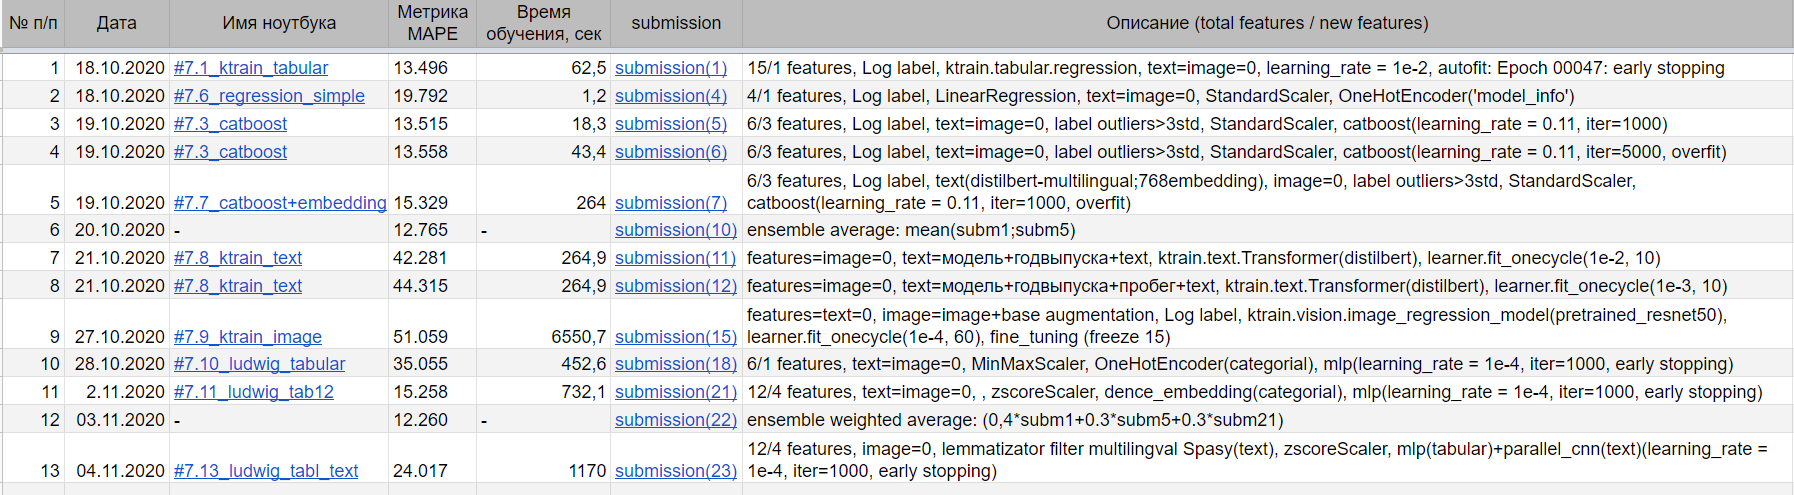

1. **Загрузка** **датасета** 


In [ ]:
!pip install kaggle
import json
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c sf-dst-car-price-prediction-part2 -p /content

Saving kaggle.json to kaggle.json
  0% 0.00/18.0k [00:00<?, ?B/s]
100% 18.0k/18.0k [00:00<00:00, 7.10MB/s]
  0% 0.00/24.3k [00:00<?, ?B/s]
100% 24.3k/24.3k [00:00<00:00, 21.5MB/s]
  0% 0.00/19.5k [00:00<?, ?B/s]
100% 19.5k/19.5k [00:00<00:00, 20.8MB/s]
  0% 0.00/16.7k [00:00<?, ?B/s]
100% 16.7k/16.7k [00:00<00:00, 15.7MB/s]
  0% 0.00/19.8k [00:00<?, ?B/s]
100% 19.8k/19.8k [00:00<00:00, 20.8MB/s]
  0% 0.00/21.9k [00:00<?, ?B/s]
100% 21.9k/21.9k [00:00<00:00, 23.0MB/s]
  0% 0.00/23.1k [00:00<?, ?B/s]
100% 23.1k/23.1k [00:00<00:00, 24.5MB/s]
  0% 0.00/27.1k [00:00<?, ?B/s]
100% 27.1k/27.1k [00:00<00:00, 25.6MB/s]
  0% 0.00/23.9k [00:00<?, ?B/s]
100% 23.9k/23.9k [00:00<00:00, 25.3MB/s]
  0% 0.00/22.1k [00:00<?, ?B/s]
100% 22.1k/22.1k [00:00<00:00, 20.2MB/s]
  0% 0.00/21.6k [00:00<?, ?B/s]
100% 21.6k/21.6k [00:00<00:00, 23.4MB/s]
  0% 0.00/19.2k [00:00<?, ?B/s]
100% 19.2k/19.2k [00:00<00:00, 19.5MB/s]
  0% 0.00/26.6k [00:00<?, ?B/s]
100% 26.6k/26.6k [00:00<00:00, 27.6MB/s]
  0% 0.00/19.7k [

In [ ]:

!unzip /content/test.csv.zip

!unzip /content/train.csv.zip


Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/train.csv.zip
  inflating: train.csv               


In [ ]:
import pandas as pd
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv('/content/test.csv')
sample_submission = pd.read_csv("/content/sample_submission.csv")


**2. Анализ и предобработка**

In [ ]:
train_df.isnull().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                4326
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

In [ ]:
train_df.head(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый


In [ ]:
#выбросы и логарифм таргета
import numpy as np


#train_df = train_df[np.abs(train_df.price-train_df.price.mean())<=(3*train_df.price.std())]
train_df.price = train_df.price.apply(lambda w: np.log1p(w))

**3. Слить - добавка новых фич - препроцессинг - разлить**

In [ ]:
train_df.shape, test_df.shape

((6682, 22), (1671, 21))

In [ ]:
X = train_df.append(test_df,ignore_index=True)


In [ ]:
X.enginePower=X.enginePower.apply(lambda x:x.split(' ')[0]).astype('int')
X['Владельцы'] = X['Владельцы'].str.extract('(\d+)')
X['Владельцы'] = X['Владельцы'].apply(lambda x: 5 if x=='1' else 3 if x=='2' else 1).astype('int')
X.modelDate = X.modelDate.astype('string')
X['model'] = X.model_info + ' ' + X.modelDate
X.productionDate = X.productionDate.apply(lambda x:2020-x)
del X['modelDate']
del X['model_info']

In [ ]:
DIR_img = '/content/drive/My Drive/ДляВСЕХ/img/img'
train_df.sell_id = train_df.sell_id.apply(lambda x: DIR_img + '/' + str(x) + '.jpg' )
test_df.sell_id = test_df.sell_id.apply(lambda x: DIR_img + '/' + str(x) + '.jpg' )

In [ ]:
train_df = X[:6682]
test_df = X[6682:]
del test_df['price']
test_df.shape

(1671, 20)

In [ ]:
train_df.head(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,model
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272,бензин,245000,530xi 3.0 AT (272 л.с.) 4WD,4,13.303019,13,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,1,NaN,Оригинал,полный,Левый,5ER 2007
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204,бензин,183000,2.8 CVT (204 л.с.),4,13.652993,9,1095836906,SEDAN VARIATOR 2.8,вариатор,3,8 лет и 6 месяцев,Оригинал,передний,Левый,A6 2011
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306,бензин,122733,350 3.5 AT (306 л.с.) 4WD,4,14.096924,7,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,1,NaN,Оригинал,полный,Левый,E_KLASSE 2009


**4. Загрузка фреймворка и модели**

In [ ]:
!pip install ludwig
from ludwig.api import LudwigModel

     |████████████████████████████████| 215kB 5.2MB/s 
     |████████████████████████████████| 1.1MB 18.5MB/s 
  Created wheel for ludwig: filename=ludwig-0.3-cp36-none-any.whl size=283601 sha256=63f96e027ca624154408f491efa3d6b12d5abbf24c1a97a83cb6c1942e640d10
  Stored in directory: /root/.cache/pip/wheels/a5/35/b9/552a8c30522277235808383339fff725d1f374958b20896da9
Successfully built ludwig


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6681 entries, 0 to 6680
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             6681 non-null   object 
 1   brand                6681 non-null   object 
 2   color                6681 non-null   object 
 3   description          6681 non-null   object 
 4   enginePower          6681 non-null   int64  
 5   fuelType             6681 non-null   object 
 6   mileage              6681 non-null   int64  
 7   model_info           6681 non-null   object 
 8   numberOfDoors        6681 non-null   int64  
 9   price                6681 non-null   float64
 10  productionDate       6681 non-null   int64  
 11  sell_id              6681 non-null   int64  
 12  vehicleTransmission  6681 non-null   object 
 13  Владельцы            6681 non-null   int64  
 14  ПТС                  6681 non-null   object 
 15  Привод               6681 non-null   o

In [ ]:
config ={ 
  "training":
        {"batch_size":32,"epochs":1000,"early_stop":50,"learning_rate":0.001},
  "input_features":[
        {"name":"bodyType","type":"category"},
        {"name":"brand","type":"category"},
        {"name":"color","type":"category"},          
#        {"name":"description","type":"text","level":"word","encoder":"parallel_cnn"},
        {"name":"enginePower","type":"numerical","normalization":"zscore"},
        {"name":"fuelType","type":"category"},
        {"name":"mileage","type":"numerical","normalization":"zscore"},
        {"name":"model","type":"category"},
        {"name":"numberOfDoors","type":"category"},
        {"name":"productionDate","type":"numerical","normalization":"zscore"},
#        {"name":"vehicleTransmission","type":"category"},
        {"name":"ПТС","type":"category"},
        {"name":"Привод","type":"category"},
#        {"name":"Руль","type":"category"},
#        {"name":"sell_id","type":"image","encoder":"stacked_cnn",
#              "preprocessing":{"width":240,"height":320,"num_channels":3,"resize_image":"true"}},
        {"name":"Владельцы","type":"numerical","normalization":"zscore"}],
  "output_features":[
        {"name":"price","type":"numerical","optimizer":{"type":"mean_absolute_error"},
         "num_fc_layers":2, "fc_size": 64}]}

ludwig_model = LudwigModel(config)

**5. Обучение**

In [ ]:
train_stats, _, _ = ludwig_model.train(dataset=train_df)

/usr/local/lib/python3.6/dist-packages/ludwig/data/preprocessing.py:1045: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  computed_fill_value,


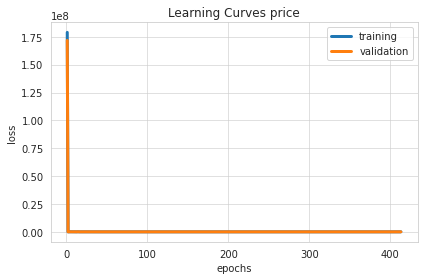

In [ ]:
#
from ludwig import visualize
visualize.learning_curves(
  [train_stats],
  "price",
  model_names=None,
  output_directory=None,
  file_format='pdf'
)

In [ ]:
train_stats

{'test': OrderedDict([('price',
               OrderedDict([('loss',
                             [165476350.0,
                              9078.008,
                              51844.383,
                              11935.477,
                              47272.652,
                              37814.04,
                              41438.555,
                              18867.115,
                              18879.516,
                              22869.504,
                              24824.271,
                              7894.6973,
                              10255.052,
                              66826.32,
                              1213.879,
                              2175.7722,
                              21850.195,
                              19213.934,
                              4417.8965,
                              578.3149,
                              10392.886,
                              5088.4585,
                              24

**7. Предсказание на тесте  и формирование submission**

In [ ]:
predictions, _ = ludwig_model.predict(dataset=test_df)

predictions.shape

/usr/local/lib/python3.6/dist-packages/ludwig/data/preprocessing.py:1045: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  computed_fill_value,


(1671, 1)

In [ ]:
sample_submission.price = np.expm1(predictions)

In [ ]:
sample_submission.price = predictions

In [ ]:
sample_submission

,sell_id,price
0,1099427284,6.760112e+05
1,1096405886,2.640255e+06
2,1100195294,6.763981e+05
3,1099827282,5.581382e+05
4,1100076198,2.876106e+06
...,...,...
1666,1099414488,1.187238e+06
1667,1099277058,2.569865e+06
1668,1098773964,1.542106e+06
1669,1098835932,1.106395e+06


In [ ]:
sample_submission.to_csv('submission.csv', index=False)
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>